In [623]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
np.set_printoptions(precision=5)
import datetime as datetime 





In [624]:
## global Variables
alpha = 1/5.8
gamma = 1/5
epsilon = 0.66
N = 70 * pow(10,6)



In [625]:
def get_data(file_path='COVID19_data.csv'):
    
    data = pd.read_csv(file_path)
    start_pos = data[data['Date'] == '2021-03-16'].index[0]

    V_t  = data['First Dose Administered'].values
    T_t = data['Tested'].values
    C_t = data['Confirmed'].values

    V_t_new = V_t[start_pos:start_pos+42] # 16th March to 26 April
    T_t_new = T_t[start_pos:start_pos+188] # march to 19th September
    C_t_new = C_t[start_pos:start_pos+188]  # 16th March to 19th September
    
    T_t_new = np.diff(T_t_new,prepend =0) 
    T_t_new[0] = T_t[start_pos]-T_t[start_pos-1]
    C_t_new = np.diff(C_t_new,prepend =0) 
    C_t_new[0] = C_t[start_pos]-C_t[start_pos-1]
    
    return V_t_new,C_t_new,T_t_new


In [626]:
V_t,C_t,T_t=get_data()

In [627]:
def get_CIR_t(CIR0):
    CIR_t = np.zeros(291) # 291 corresponds to 31st dec
    for i in range(0,188):
        if i<7:
            CIR_t[i] = CIR0*T_t[0]/np.mean(T_t[0:i+1])
        else:
            CIR_t[i] = CIR0*T_t[0]/np.mean(T_t[i-7:i-1])
    for i in range(188,291):
        CIR_t[i]=CIR_t[187]
    return CIR_t

In [628]:
def get_c_t(days):
    
    c_t = np.zeros(days)              # stores 7 day running average of confirmed cases on each day from 16th March to 26th April
    for i in range(0,days):
        if i<7:
            c_t[i] = np.mean(C_t[0:i+1])
        else:
            c_t[i] = np.mean(C_t[i-6:i+1]) 
    return c_t


In [630]:
def Delta_V(i):
    if i<41:
        delta_V_t = V_t[i+1]-V_t[i]
    else:
        delta_V_t = 2*pow(10,5) ## 2 lakh vaccinations from 27th April
    return delta_V_t
    

In [631]:
def Delta_W(i): # No change made

    if i<30:
        delta_W_t = R_t[0]/30
        
    elif i>=30 and i<180:
        delta_W_t = 0
    elif i>=180:
        if i-179<42:
            delta_W_t = (R_t[i-179]-R_t[i-180]) + epsilon*(V_t[i-179] - V_t[i-180])
        else:
            delta_W_t = (R_t[i-179]-R_t[i-180]) + epsilon*2*pow(10,5)
    return delta_W_t
  

In [632]:
def model(beta,i):
    S_t[i+1] = S_t[i] - beta*S_t[i]*(I_t[i]/N) - epsilon*Delta_V(i) + Delta_W(i)
    E_t[i+1] = E_t[i] + beta*S_t[i]*(I_t[i]/N) - alpha*E_t[i]
    I_t[i+1] = I_t[i] + alpha*E_t[i] - gamma*I_t[i]
    R_t[i+1] = R_t[i] + gamma*I_t[i] +  epsilon*Delta_V(i) - Delta_W(i)
    

In [633]:
def loss(x):
    b,S_t[0],E_t[0],I_t[0],R_t[0],CIR0=x[0],x[1],x[2],x[3],x[4],x[5]
    S_t[0]=N-E_t[0]-I_t[0]-R_t[0]
    for t in range(days-1):
        model(b,t)   
    CIR_t = get_CIR_t(CIR0)[0:42]   # from 16th march to 26th april
    c_t   = get_c_t(42) # from 16th march to 26th april
    e_t = np.divide(E_t,CIR_t) # from 16th march to 26th april
    mean_e_t = np.zeros(42) ## mean of delta i(t) from t-6 to t day

    i=0
    while i<42:
        if i<7:
            choice_list=[np.mean(e_t[0:i+1]),1/alpha]
            mean_e_t[i] = max(choice_list)
            i+=1
        else:
            choice_list=[np.mean(e_t[i-6:i+1]),1/alpha]
            mean_e_t[i] = max(choice_list)
            i+=1
    
    loss  = np.sum(np.square((np.log(c_t) - np.log(alpha*mean_e_t))))/42
    return loss

In [677]:
def get_estimate():
    min_loss=10000

    variation_for_param0=np.arange(0.4,0.6,0.02)
    variation_for_param2=np.arange(1,3,0.1)
    variation_for_param3=np.arange(8,9,0.1)
    variation_for_param4=np.arange(1,3,0.2)
    variation_for_param5=np.arange(12,30,1)

    

    for beta in variation_for_param0:
        for e in variation_for_param2:
            for i in variation_for_param3:
                 for r in variation_for_param4:
                        for cir in variation_for_param5:
                            if N-(e*pow(10,5)+i*pow(10,4)+r*pow(10,7))<0:
                                continue
                            estimate_at_this = np.array([beta,N-(e*pow(10,5)+i*pow(10,4)+r*pow(10,7)),e*pow(10,5),i*pow(10,4),r*pow(10,7),cir])
                            loss_at_this = loss(estimate_at_this)
                            if min_loss > loss_at_this:
                                min_loss = loss_at_this
                                estimate = estimate_at_this
                                
    return estimate 

In [639]:
def get_gradient_at(x):
    
    grad = np.zeros(6,dtype=np.float64)
    y = x.copy()
    mn = loss(x)
    res = np.zeros(6)

    

    y_1=y.copy()
    y_0=y.copy()
    
    y_1[0]=y_1[0]+0.01
    y_0[0]=y_0[0]-0.01


    delta_loss=round(loss(y_1)-loss(y_0),ndigits=3)


    delta_x=0.01-(-0.01)
    grad[0]=delta_loss/delta_x

    y_1=y.copy()
    y_0=y.copy()
    
    y_1[5]=y_1[5]+0.01
    y_0[5]=y_0[5]-0.01


    delta_loss=round(loss(y_1)-loss(y_0),ndigits=3)


    delta_x=0.01-(-0.01)
    grad[5]=delta_loss/delta_x

    for index in range(2,5):
        y_1=y.copy()
        y_0=y.copy()
        
        y_1[index]=y_1[index]+1
        y_0[index]=y_0[index]-1


        delta_loss=round(loss(y_1)-loss(y_0),ndigits=3)
        delta_x=1-(-1)
        grad[index]=delta_loss/delta_x

    grad[1]=-(grad[2]+grad[3]+grad[4])   # Since their sum has to be 0
    return grad

In [640]:
def do_gradient_Desc(x0,max_iter=10000,eps=0.01):

    def Project(x):
        
        if x[4]>=R0_upper:
            x[4]=R0_upper
        elif x[4]<=R0_lower:
            x[4]=R0_lower
        
        if x[5]>=CIR0_upper:
            x[5]=CIR0_upper
        elif x[5]<=CIR0_lower:
            x[5]=CIR0_lower
        

        if x[2] + x[3]+x[4]>N:
            tot = x[2]+x[3]+x[4]
            x[2] = x[2]*(N/tot)
            x[3] = x[3]*(N/tot)
            x[4] = x[4]*(N/tot)

        x[1] = N - x[2]-x[3]-x[4]

        return x  
    
    i=0
    j=0
    x=x0
    u=1000
    
    while u>eps and j<max_iter:
        
        grad_f_at_x= get_gradient_at(x)
        x=Project(x-((grad_f_at_x)/(1+j)))
        u = loss(x)
        if i%1000==0:
            print(u)
        j+=1
        i=i+1
    return x,u

In [672]:
def plot_to_validate(x):

    global S_t,E_t,I_t,R_t

    days=42
    S_t = np.zeros(days)
    E_t = np.zeros(days)
    I_t = np.zeros(days)
    R_t = np.zeros(days)

    

    b,S_t[0],E_t[0],I_t[0],R_t[0],CIR0=x[0],x[1],x[2],x[3],x[4],x[5]
    #Safety operation to ensure conservation of population
    S_t[0]=N-E_t[0]-I_t[0]-R_t[0]

    for t in range(days-1):
        model(b,t)
           
    CIR_t = get_CIR_t(CIR0)[0:42] # from 16th march to 26th april
    c_t   = get_c_t(42) # from 16th march to 26th april
    e_t = np.divide(E_t,CIR_t) # from 16th march to 26th april
    mean_e_t = np.zeros(42) ## mean of delta i(t) from t-6 to t day

    i=0
    while i<42:
        if i<7:
            choice_list=[np.mean(e_t[0:i+1]),1/alpha]
            mean_e_t[i] = max(choice_list)
            i+=1
        else:
            choice_list=[np.mean(e_t[i-6:i+1]),1/alpha]
            mean_e_t[i] = max(choice_list)
            i+=1
    
    plt.subplot(121)
    plt.xlabel('days')
    plt.ylabel('log(cases)')
    plt.title('From CSV')
    plt.scatter(x=range(42),y=np.log10(c_t))
    plt.subplot(122)
    plt.xlabel('days')
    plt.ylabel('log(cases)')
    plt.title(f'Predicted Loss={loss(x):.4f}')
    plt.scatter(x=range(42),y=np.log10(mean_e_t))
    plt.show()
    plt.clf()

In [666]:
def plot_till_Dec_open_loop(xopt):

    global S_t,E_t,I_t,R_t

    days = (datetime.date(2021,12,31)-datetime.date(2021,3,16)).days

    #optimal set of paramters
    beta,CIR0 = xopt[0],xopt[5]
    S_t = np.zeros(days)
    E_t = np.zeros(days)
    I_t = np.zeros(days)
    R_t = np.zeros(days)

    for x in [1,2/3,1/2,1/3]:
        b = beta*x
        #Simulating SEIRV with optimal parameters

        S_t[0],E_t[0],I_t[0],R_t[0] = xopt[1],xopt[2],xopt[3],xopt[4]

        for t in range(days-1):
            model(b,t)
        CIR_t = get_CIR_t(CIR0)[0:days] # from 16th march to 31st Dec
        e_t = np.divide(E_t,CIR_t) # from 16th march to 31st Dec
        mean_e_t = np.zeros(days) ## mean of delta i(t) from t-6 to t day

        i=0
        while i<days:
            if i<7:
                choice_list=[np.mean(e_t[0:i+1]),1/alpha]
                mean_e_t[i] = max(choice_list)
                i+=1
            else:
                choice_list=[np.mean(e_t[i-6:i+1]),1/alpha]
                mean_e_t[i] = max(choice_list)
                i+=1
                
        plt.xlabel('days')
        plt.ylabel('# of cases')
        plt.title(f'The evolution of number of cases till dec 31st with beta ={b:.3f}')
        plt.plot(e_t)
        plt.plot()
        plt.show()
        plt.clf()

        plt.xlabel('days')
        plt.ylabel('Fraction of Susceptible people')
        plt.title(f'The evolution of fraction of Susceptible till dec 31st with beta ={b:.3f}')
        plt.plot(S_t/N)
        plt.plot()
        plt.show()
        plt.clf()

In [664]:

def plot_comparison_with_open(xopt):
    
    days = (datetime.date(2021,9,20)-datetime.date(2021,3,16)).days
    print(days)

    global S_t,E_t,I_t,R_t

    #optimal set of paramters
    beta,CIR0 = xopt[0],xopt[5]
    S_t = np.zeros(days)
    E_t = np.zeros(days)
    I_t = np.zeros(days)
    R_t = np.zeros(days)

    for x in [1,2/3,1/2,1/3]:
        b = beta*x
        #Simulating SEIRV with optimal parameters

        S_t[0],E_t[0],I_t[0],R_t[0] = xopt[1],xopt[2],xopt[3],xopt[4]

        for t in range(days-1):
            model(b,t)
        CIR_t = get_CIR_t(CIR0)[0:days] # from 16th march to 31st Dec
        e_t = np.divide(E_t,CIR_t) # from 16th march to 31st Dec
        mean_e_t = np.zeros(days) ## mean of delta i(t) from t-6 to t day
        c_t   = get_c_t(days)

        i=0
        while i<days:
            if i<7:
                choice_list=[np.mean(e_t[0:i+1]),1/alpha]
                mean_e_t[i] = max(choice_list)
                i+=1
            else:
                choice_list=[np.mean(e_t[i-6:i+1]),1/alpha]
                mean_e_t[i] = max(choice_list)
                i+=1
                
        plt.xlabel('days')
        plt.ylabel('# of cases')
        plt.title(f'The evolution of number of cases till Sep-9 th with beta ={b:.3f}')
        plt.plot(e_t,color='r',label="Predicted with the given beta")
        plt.plot(c_t,color='g',label="Actual Number of Cases")
        plt.plot()
        plt.legend()
        plt.show()
        plt.clf()
    

In [665]:
def plot_closed_loop(xopt):
    days = (datetime.date(2021,12,31)-datetime.date(2021,3,16)).days
    print(days)

    global S_t,E_t,I_t,R_t

    #optimal set of paramters
    beta,CIR0 = xopt[0],xopt[5]
    S_t = np.zeros(days)
    E_t = np.zeros(days)
    I_t = np.zeros(days)
    R_t = np.zeros(days)


    #Simulating SEIRV with optimal parameters

    S_t[0],E_t[0],I_t[0],R_t[0] = xopt[1],xopt[2],xopt[3],xopt[4]
    CIR_t = get_CIR_t(CIR0)[0:days] # from 16th march to 31st Dec
    # Note that March 16 is a monday
    i_dash=9000 # So that b=beta to begin with.  
    for t in range(days-1):
        
        if t==1:
            i_dash=np.mean(alpha*E_t[:2])
        elif (t-1)%7==0:
            i_dash=np.mean(alpha*E_t[t-7:t])

        if i_dash < 10000:
            b = beta
        elif i_dash< 25000:
            b = 2*beta/3
        elif i_dash < 100000:
            b = beta/2
        else:
            b = beta/3
        model(b,t)




    e_t = np.divide(E_t,CIR_t) # from 16th march to 31st Dec
    mean_e_t = np.zeros(days) ## mean of delta i(t) from t-6 to t day

    i=0
    while i<days:
        if i<7:
            choice_list=[np.mean(e_t[0:i+1]),1/alpha]
            mean_e_t[i] = max(choice_list)
            i+=1
        else:
            choice_list=[np.mean(e_t[i-6:i+1]),1/alpha]
            mean_e_t[i] = max(choice_list)
            i+=1
            
    plt.xlabel('days')
    plt.ylabel('# of cases')
    plt.title(f'The evolution of number of cases till dec 31st with closed loop control over beta ')
    plt.plot(mean_e_t)
    plt.plot()
    plt.show()
    plt.clf()

    plt.xlabel('days')
    plt.ylabel('Fraction of Susceptible people')
    plt.title(f'The evolution of fraction of Susceptible till dec 31st with closed loop control over beta ')
    plt.plot(S_t/N)
    plt.plot()
    plt.show()
    plt.clf()

In [668]:
#Constraints
R0_lower =0.156*N
R0_upper=0.36*N
CIR0_lower=12
CIR0_upper=30

#Taken 7 days extra before to adjust seven week average calculation
days = 42
#Time Series to store intermediate result

S_t = np.zeros(days)
E_t = np.zeros(days)
I_t = np.zeros(days)
R_t = np.zeros(days)

estimate=get_estimate()
opt_param,opt_loss=do_gradient_Desc(estimate)



0.0005834459946369414


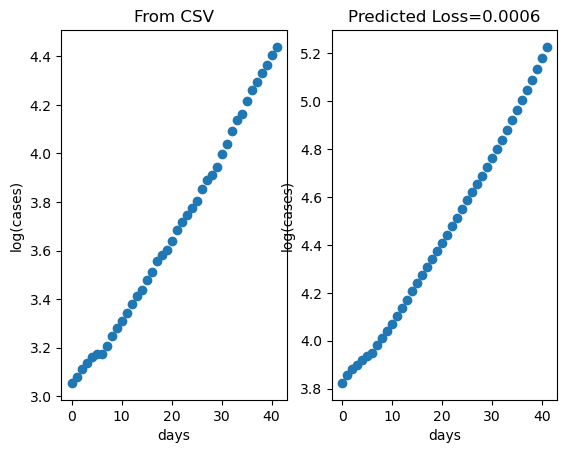

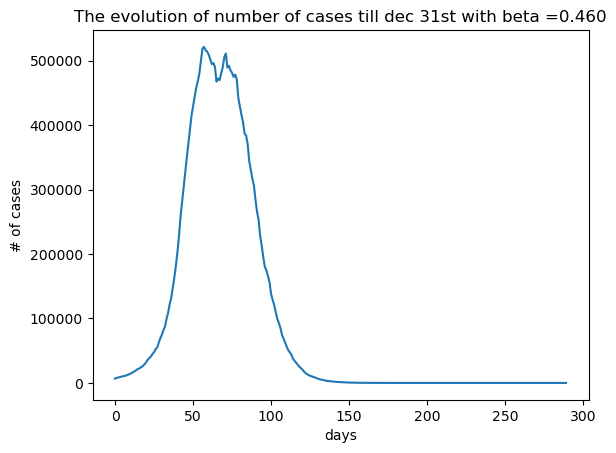

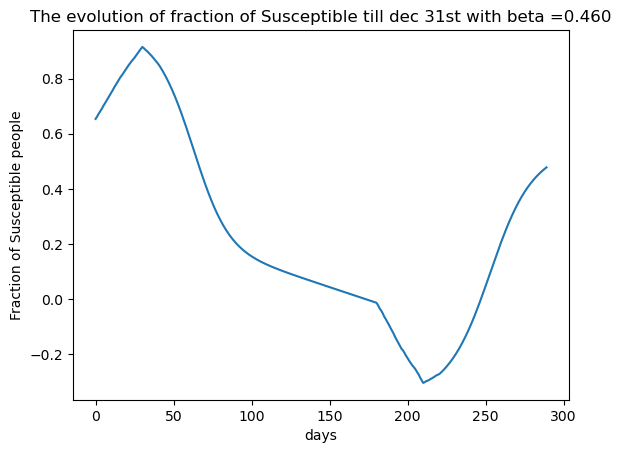

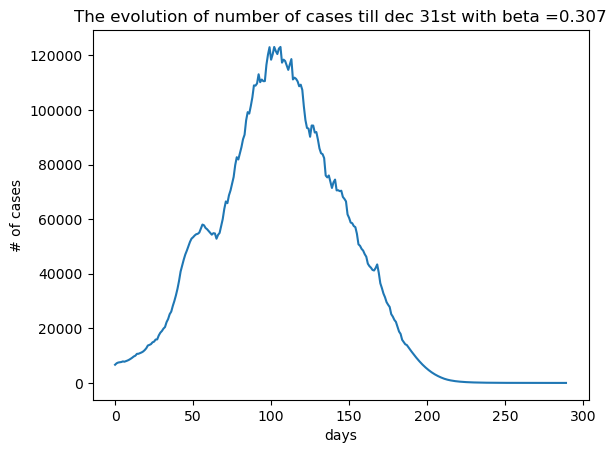

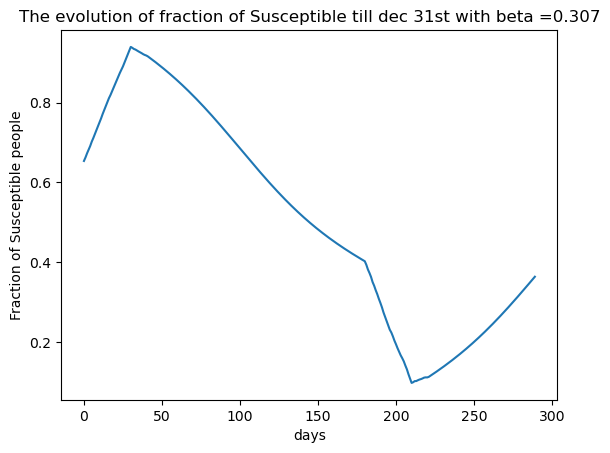

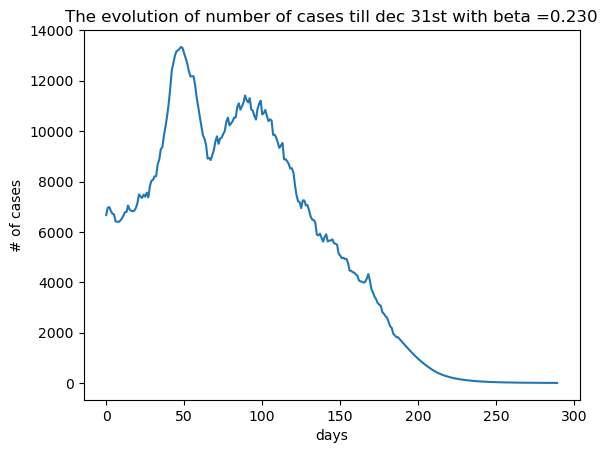

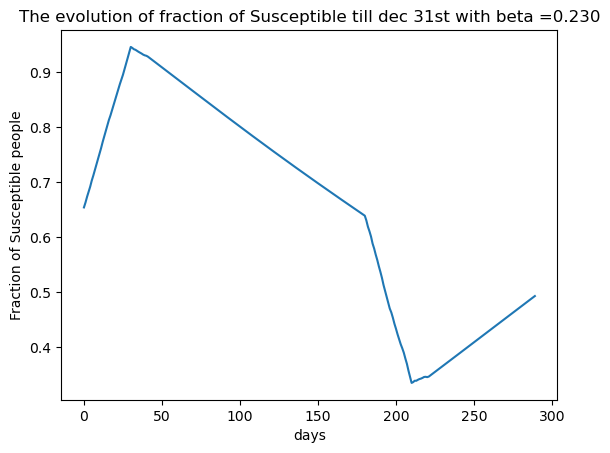

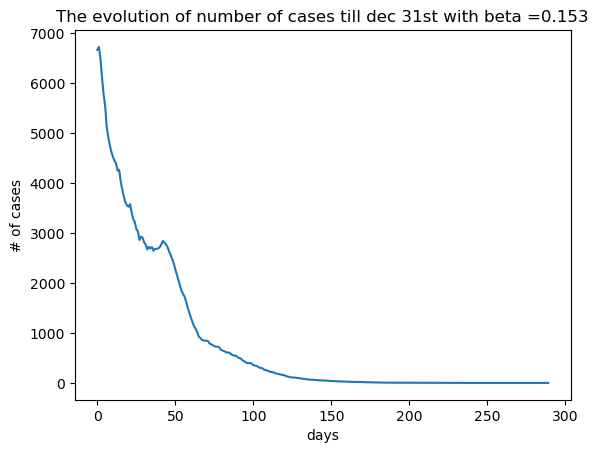

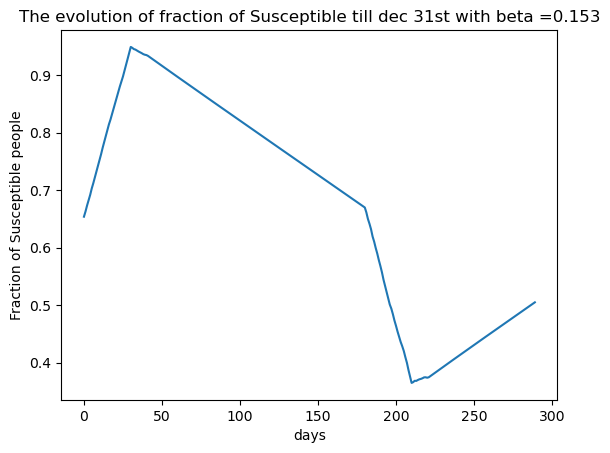

188


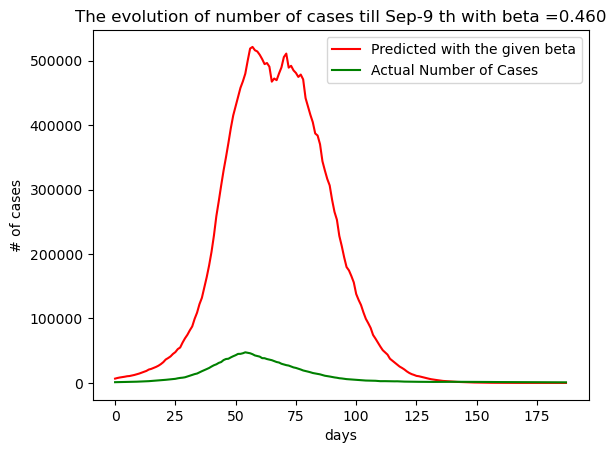

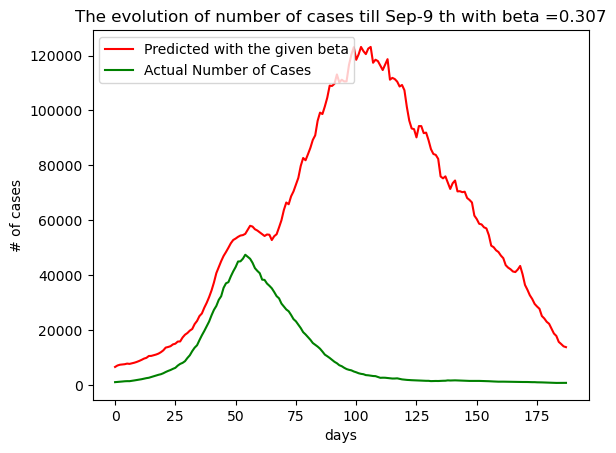

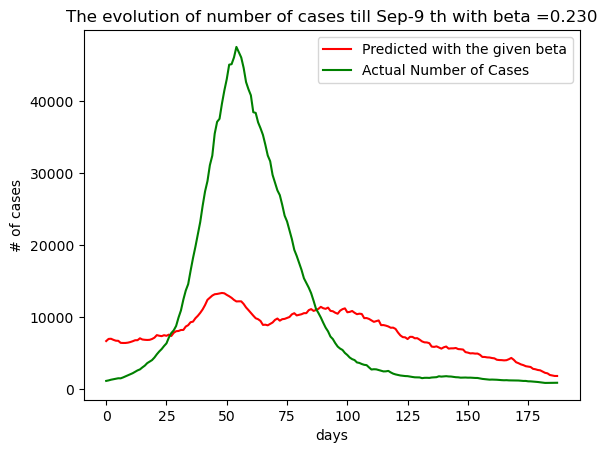

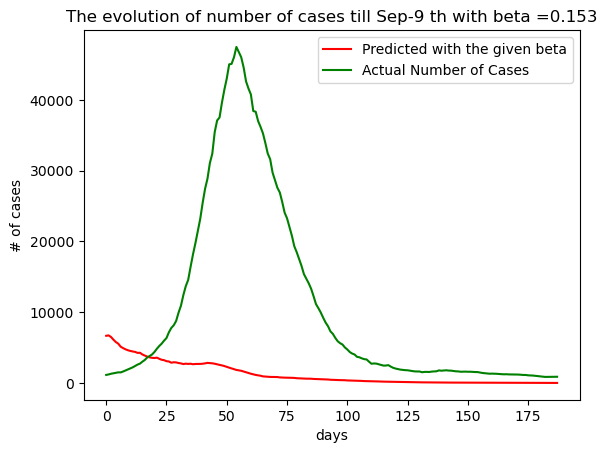

290


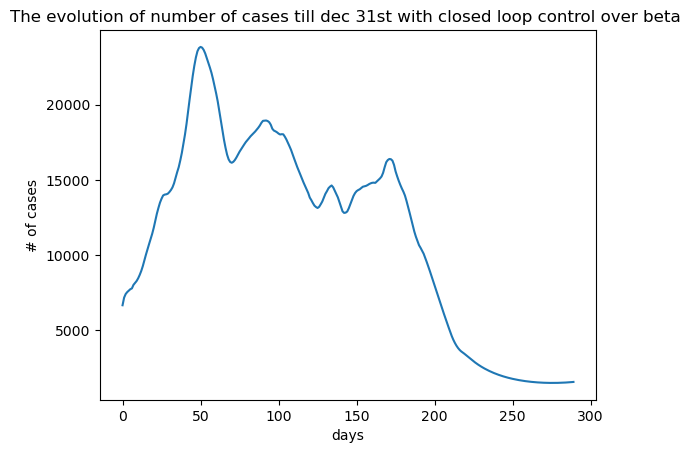

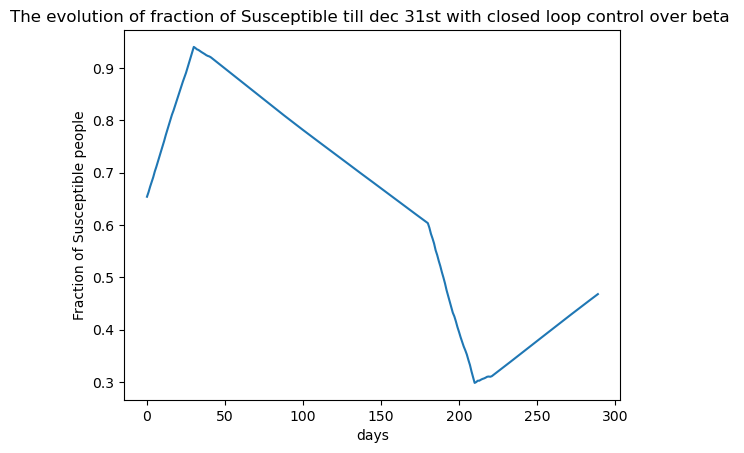

<Figure size 640x480 with 0 Axes>

In [676]:
plot_to_validate(opt_param)
plot_till_Dec_open_loop(opt_param)
plot_comparison_with_open(opt_param)
plot_closed_loop(opt_param)
